In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# References

- [SKTBrain/KoBERT](https://github.com/SKTBrain/KoBERT)
- [eagle705/pytorch-bert-crf-ner](https://github.com/eagle705/pytorch-bert-crf-ner/blob/master/Visualization_BERT_NER.ipynb)
- [BERT to the rescue!](https://towardsdatascience.com/bert-to-the-rescue-17671379687f)

# Load pre-trained model

In [85]:
import io

import pandas as pd
import numpy as np

import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams['font.family'] = 'NanumGothic'

import torch
import torch.nn as nn
from kobert.pytorch_kobert import get_pytorch_kobert_model
from gluonnlp.data import SentencepieceTokenizer
from kobert.utils import get_tokenizer
import sentencepiece as spm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, vocab = get_pytorch_kobert_model()
model.to(device)

using cached model
using cached model


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(8002, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Line

In [81]:
# Load pre-trained model tokenizer
tok_path = get_tokenizer()
print(tok_path)
sp = spm.SentencePieceProcessor()
print(sp)
sp.Load(tok_path)

# Tokenized input
#text = "[CLS] 누가 기침소리를 내었는가 ? [SEP] 누구인가 ? [SEP]"
text = "누가 기침소리를 내었는가 ? 누구인가 ?"
tokenized_text = sp.EncodeAsPieces(text)
indexed_tokens = vocab.to_indices(tokenized_text)
reconstructed = vocab.to_tokens(indexed_tokens)

print(text)
print(tokenized_text)
print(indexed_tokens)
print(reconstructed)

using cached model
/root/kobert/tokenizer_78b3253a26.model
<sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7fcc54896660> >
누가 기침소리를 내었는가 ? 누구인가 ?
['▁누가', '▁기', '침', '소리', '를', '▁내', '었', '는', '가', '▁?', '▁누구', '인', '가', '▁?']
[1527, 1258, 7491, 6609, 6116, 1434, 6885, 5760, 5330, 633, 1528, 7119, 5330, 633]
['▁누가', '▁기', '침', '소리', '를', '▁내', '었', '는', '가', '▁?', '▁누구', '인', '가', '▁?']


# Load Data and Merge

In [60]:
# Load and preprocess
reply = pd.read_csv('data/example/reply_005930.csv', index_col=0).reset_index(drop=True)
price = pd.read_csv('data/example/price_005930.csv', index_col=0)
print(reply.shape)
#display(reply[0:2])
print(price.shape)
#display(price[0:5])

# wrong data in the dataframe
#display(pd.DataFrame(reply.iloc[209]).T)
#display(pd.DataFrame(reply.iloc[210]).T)

# convert timestamp of reply dataframe as datetime object, drop wrong rows
list_to_drop = []
with tqdm.tqdm(total=reply.shape[0]) as pbar : 
    for i in range(reply.shape[0]) : 
        try : 
            reply['Date'].iloc[i] = pd.to_datetime(reply['Date'].iloc[i], format='%Y.%m.%d %H:%M')
            pbar.update(1)
        except Exception as e :
            list_to_drop.append(i)
            pbar.update(1)
reply = reply.drop(list_to_drop, axis=0)
        
# convert timestamp of price dataframe as datetime object
with tqdm.tqdm(total=price.shape[0]) as pbar :
    for i in range(price.shape[0]) : 
        price['time'].iloc[i] = pd.to_datetime(str(price['date'].iloc[i])+str(price['time'].iloc[i]), format='%Y%m%d%H%M')
        pbar.update(1)
        
# sort in ascending order
reply = reply.sort_values(by='Date').reset_index(drop=True)
price = price.sort_values(by='time').reset_index(drop=True)
reply.index = reply['Date']
reply = reply.drop(['Date'], axis=1)
price.index = price['time']
pirce = price.drop(['date', 'time'], axis=1)

display(reply)
display(price)

  0%|          | 78/20129 [00:00<00:25, 779.62it/s]

(20129, 7)
(3429, 7)


100%|██████████| 3429/3429 [00:03<00:00, 906.45it/s] 


,Views,Title,Content,Like,Unlike,Ip
Date,,,,,,
2019-10-08 11:22:00,93,홍어도,홍어 먹으로 가야는되 어느지역으로 가야 하냐알려다오 홍어도 사람들아,1.0,0.0,223.38.***.169
2019-10-08 11:23:00,67,[삭제된 게시물의 답글]박원숭 렉서스 잘굴러가냐??,아들은 찾았고?? 딸는 아직도 돈많이든다는 스위스 유학중이고??? 미누라 일감은 ...,4.0,0.0,125.139.***.71
2019-10-08 11:27:00,108,자격없는 문재인 때문에,나라가 요지경 \r\r\nㅂㅅ 문재인,8.0,4.0,58.238.***.52
2019-10-08 11:28:00,103,박원순 사람이 5명이나 죽었다 니가 불렀자나??,니가 불렀자나??? 니가 그런거자나???? 책임져야하자나??? 양심은 어따팔아...,4.0,0.0,125.139.***.71
2019-10-08 11:29:00,116,"검찰, '갑자기 허리 수술' 조국 동생 부산서 강제 구인...!",영장심사 오후에 열릴 듯--조선일보,8.0,0.0,211.114.***.78
...,...,...,...,...,...,...
2019-11-12 23:32:00,22,아베 자서전,아베가\r\r\n자기 조상이\r\r\n즐라 홍어인 이라고 자서전에서 고백\r\r\n...,0.0,0.0,115.86.***.36
2019-11-12 23:34:00,15,아베는 백제 씨다 딱 보면 이낙연도 백제 사람은 뽐내기를 좋아하는,부산사람과 속 마음자체가 달라 마음속 가치를 중시한다 점 잖은 사람을 더 좋아 한다,0.0,0.0,1.227.***.123
2019-11-12 23:34:00,41,개떡치는 미증시 정신업따 ㅋ,애플 연일 신고가 행진 ㅋ,2.0,0.0,124.199.***.50


,close,date,high,low,open,time,vol
time,,,,,,,
2019-10-31 09:01:00,50900,20191031,51100,50900,51000,2019-10-31 09:01:00,580976
2019-10-31 09:02:00,51100,20191031,51100,50900,50900,2019-10-31 09:02:00,46699
2019-10-31 09:03:00,51100,20191031,51100,51000,51100,2019-10-31 09:03:00,13198
2019-10-31 09:04:00,51000,20191031,51100,51000,51100,2019-10-31 09:04:00,37929
2019-10-31 09:05:00,51000,20191031,51100,50900,51000,2019-10-31 09:05:00,83816
...,...,...,...,...,...,...,...
2019-11-12 15:17:00,52400,20191112,52500,52400,52500,2019-11-12 15:17:00,12420
2019-11-12 15:18:00,52500,20191112,52500,52400,52400,2019-11-12 15:18:00,20269
2019-11-12 15:19:00,52500,20191112,52500,52400,52500,2019-11-12 15:19:00,18480


In [79]:
day_start = max(price.index[0], reply.index[0])
day_end = min(price.index[-1], reply.index[-1])
print(day_start)
print(day_end)

2019-10-31 09:01:00
2019-11-12 15:30:00


,Views,Title,Content,Like,Unlike,Ip,close,date,high,low,open,time,vol
key_0,,,,,,,,,,,,,
2019-10-31 09:01:00,192.0,계엄령 문건 덮었다는 '윤석열 직인'···알고보니 자동 출력,\r\n이젠 호모쉐퀴들도 부역자 노릇을 하는구나\r\r\n \r\n군대도 안다녀온...,6.0,4.0,125.178.***.115,50900.0,20191031.0,51100.0,50900.0,51000.0,2019-10-31 09:01:00,580976.0
2019-10-31 09:01:00,544.0,오늘 실적발표 일...,자료는 공개되었네요\r\r\n못보신 분들은 확인하세요\r\r\n \r\nhttps:...,0.0,0.0,112.216.***.242,50900.0,20191031.0,51100.0,50900.0,51000.0,2019-10-31 09:01:00,580976.0
2019-10-31 09:03:00,135.0,지금은 `폴더블폰` 시대…화면 확장 한계 넘는다ㅋ,ㅋㅋ,0.0,0.0,223.62.***.176,51100.0,20191031.0,51100.0,51000.0,51100.0,2019-10-31 09:03:00,13198.0
2019-10-31 09:04:00,148.0,"삼성, 새로운 폴더블폰 공개…'갤럭시 폴드는 시작일 뿐'ㅋ",ㅋㅋ,0.0,0.0,223.62.***.176,51000.0,20191031.0,51100.0,51000.0,51100.0,2019-10-31 09:04:00,37929.0
2019-10-31 09:05:00,203.0,"삼성, 내년 폴더블폰 판매 10배 이상 늘린다…최대 600만대 달할 듯ㅋ",ㅋㅋ,3.0,0.0,223.62.***.176,51000.0,20191031.0,51100.0,50900.0,51000.0,2019-10-31 09:05:00,83816.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-12 15:16:00,NaN,NaN,NaN,NaN,NaN,NaN,52500.0,20191112.0,52500.0,52400.0,52500.0,2019-11-12 15:16:00,15225.0
2019-11-12 15:18:00,NaN,NaN,NaN,NaN,NaN,NaN,52500.0,20191112.0,52500.0,52400.0,52400.0,2019-11-12 15:18:00,20269.0
2019-11-12 15:19:00,NaN,NaN,NaN,NaN,NaN,NaN,52500.0,20191112.0,52500.0,52400.0,52500.0,2019-11-12 15:19:00,18480.0


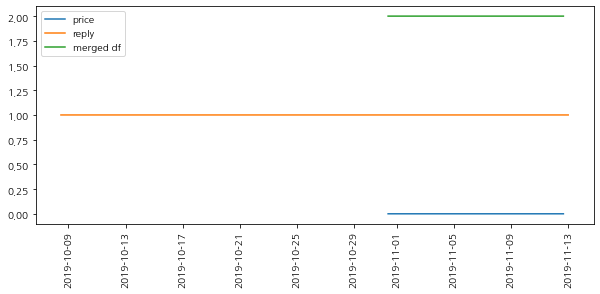

In [82]:
# merge dataframe
reply_common = reply[(reply.index >= day_start) & (reply.index <= day_end)]
price_common = price[(price.index >= day_start) & (price.index <= day_end)]
df = reply_common.merge(price_common, how='outer', left_on=reply_common.index, right_on=price_common.index)
df.index = df['key_0']
df = df.drop(['key_0'], axis=1)
display(df)

# check intersection of timestamp
plt.figure(figsize=(10, 4))
plt.plot(price.index, np.zeros(price.shape[0]), label='price')
plt.plot(reply.index, np.ones(reply.shape[0]), label='reply')
plt.plot(df.index, np.full(df.shape[0], 2), label='merged df')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Model

In [89]:
class BertRegressor(nn.Module) : 
    def __init__(self) : 
        super(BertRegressor, self).__init__()
        self.bert, self.vocab = get_pytorch_kobert_model()
        self.relu = nn.ReLU()
        self.linear = nn.Linear(768, 1)
    
    def forward(self, tokens) : 
        _, pooled_output = self.bert(tokens, utput_all=False)
        linear_output = self.relu(pooled_output)
        predicted_price = self.linear(linear_output)

        return predicted_price

In [93]:
bert_reg = BertRegressor()
bert_reg.to(device)
optimizer = torch.optim.Adam(bert_reg.parameters(), lr=3e-6)
bert_reg.train()

using cached model
using cached model


BertRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
      

# Preprocess Input Data